## Семинар 9: "LSTM"[SOLVED]

ФИО:Подоприхин Максим Александрович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden = [Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1))]):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

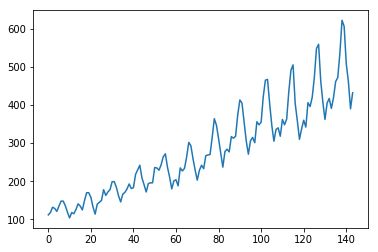

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
dataset

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [7]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [8]:
# Пример подготовленных данных

look_back = 5
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [10]:
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [17]:
loss_func = nn.MSELoss()
def check(model, look_back=5, hidden=1, look_forward=1):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    trainX, trainY = create_dataset(train, look_back, look_forward)
    testX, testY = create_dataset(test, look_back, look_forward)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    losses = []
    for epoch in range(100):
        for i in range(len(trainY)):
            Y = Variable(torch.FloatTensor(trainY[i:i+1]))
            X = Variable(torch.FloatTensor(trainX[i:i+1]))
            #print(X)
            y_pred, _ = model(X)
            loss = loss_func(y_pred, Y)
            losses.append(np.array(loss.data))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    predicts = []
    for i in range(len(testY)):
        X = Variable(torch.FloatTensor(testX[i:i+1]))
        Y = Variable(torch.FloatTensor(testY[i:i+1]))
        y_pred, _ = model(X)
        #print(y_pred)
        predicts.append(np.array(y_pred.data).mean())

    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    plt.plot(losses)
    plt.title("Losses, with size of hidden layers {0}".format(hidden))
    plt.legend()
    
    ax2 = fig.add_subplot(122)
    plt.plot(np.array(predicts).reshape(-1), color = 'r')
    plt.plot(testY)
    plt.title("Prediction vs test")
    plt.legend()
    plt.show()
        

#### поизменяем параметр look_back

look_back = 1


No handles with labels found to put in legend.
No handles with labels found to put in legend.


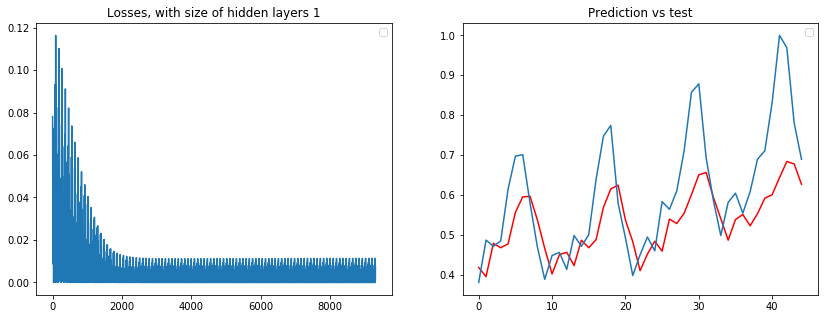

look_back = 3


No handles with labels found to put in legend.
No handles with labels found to put in legend.


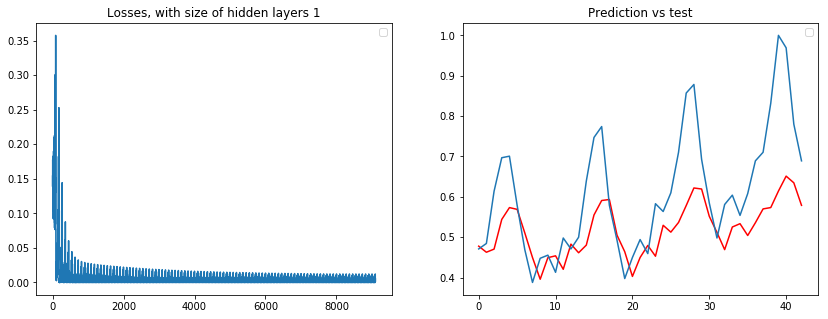

look_back = 5


No handles with labels found to put in legend.
No handles with labels found to put in legend.


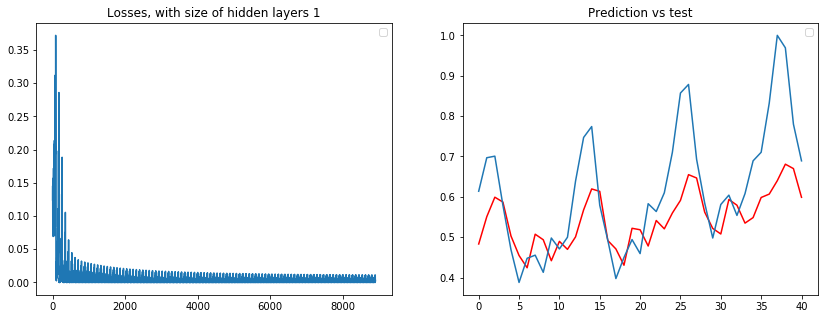

look_back = 7


No handles with labels found to put in legend.
No handles with labels found to put in legend.


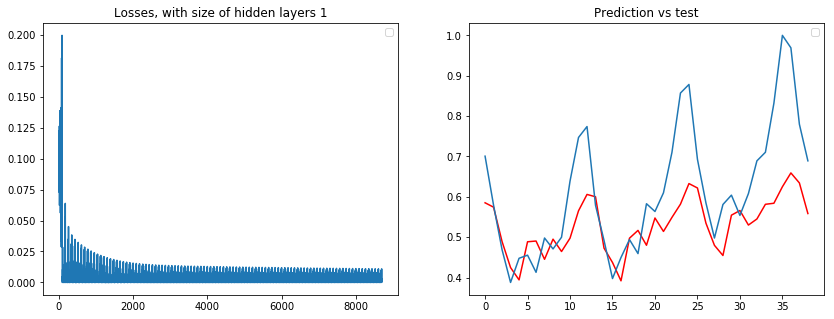

look_back = 10


No handles with labels found to put in legend.
No handles with labels found to put in legend.


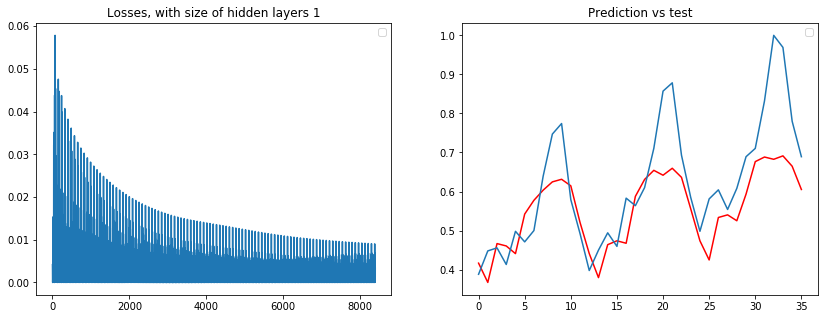

In [24]:
look_back_s = [1, 3, 5, 7, 10]
for look_back in look_back_s:
    torch_model = nn.LSTM(input_size=look_back, hidden_size=1, num_layers=1)
    print('look_back = {}'.format(look_back))
    check(torch_model, look_back)

GRU

No handles with labels found to put in legend.
No handles with labels found to put in legend.


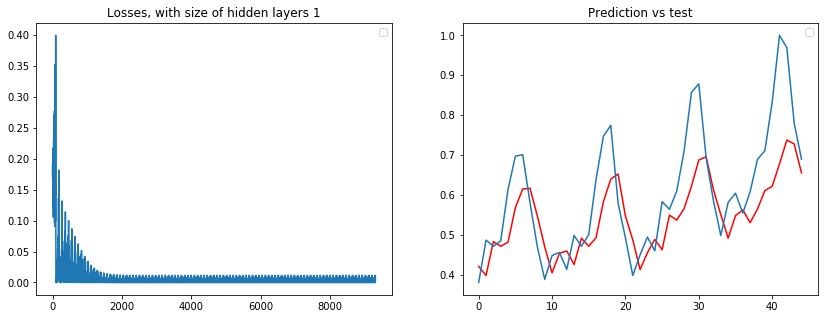

In [31]:
look_back = 1
torch_model = nn.GRU(input_size=look_back, hidden_size=1, num_layers=1)
check(torch_model, look_back)

Проверим нашу модель

No handles with labels found to put in legend.
No handles with labels found to put in legend.


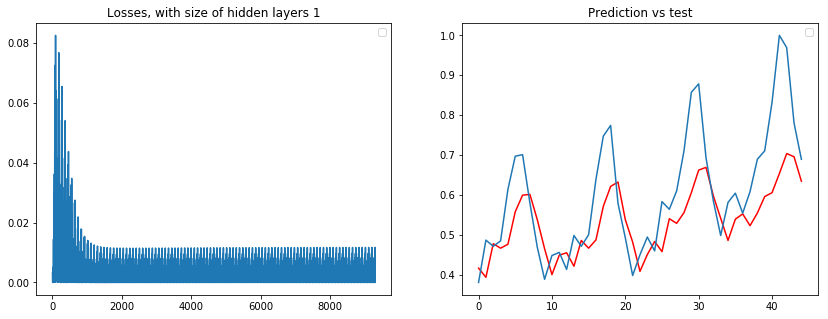

In [32]:
look_back = 1
model = LSTM(input_size=look_back, hidden_size=1)
check(model, look_back)

#### Теперь рассмотрим параметр num_layers

No handles with labels found to put in legend.
No handles with labels found to put in legend.


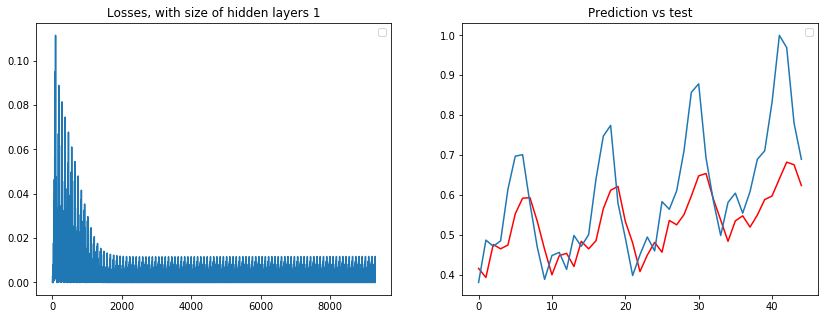

No handles with labels found to put in legend.
No handles with labels found to put in legend.


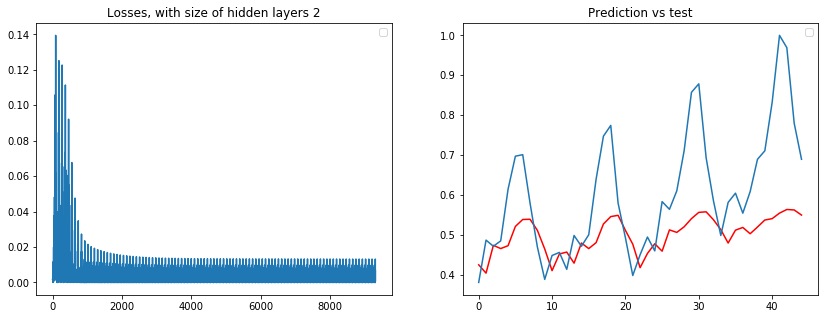

No handles with labels found to put in legend.
No handles with labels found to put in legend.


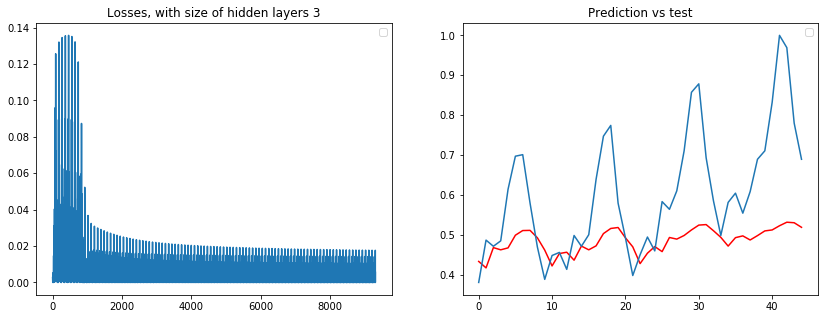

No handles with labels found to put in legend.
No handles with labels found to put in legend.


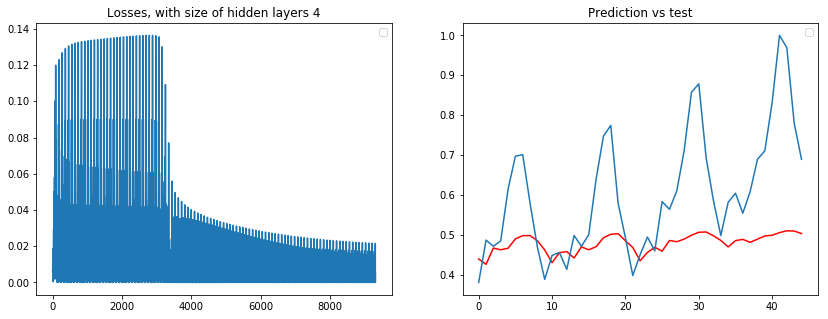

No handles with labels found to put in legend.
No handles with labels found to put in legend.


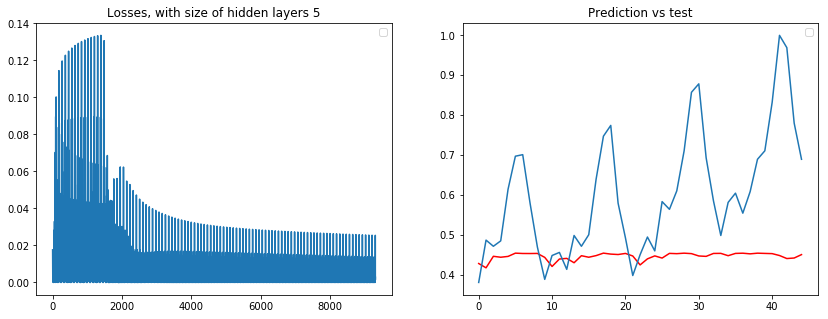

In [28]:
for i in range(1, 6):
    torch_lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=i)
    check(torch_lstm, look_back=1, hidden=i)

GRU

No handles with labels found to put in legend.
No handles with labels found to put in legend.


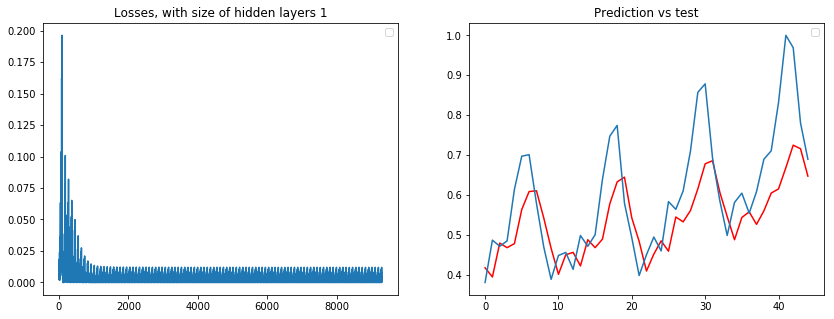

No handles with labels found to put in legend.
No handles with labels found to put in legend.


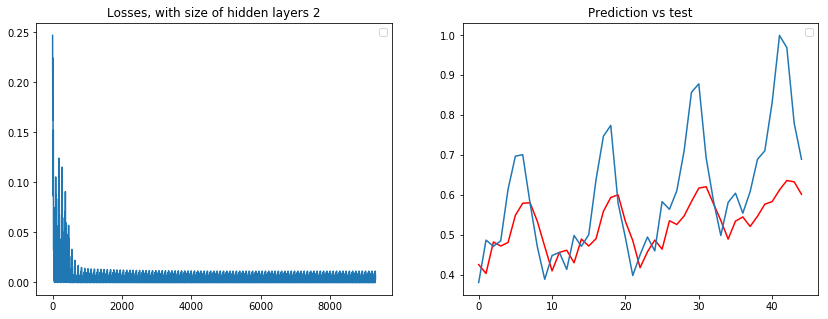

No handles with labels found to put in legend.
No handles with labels found to put in legend.


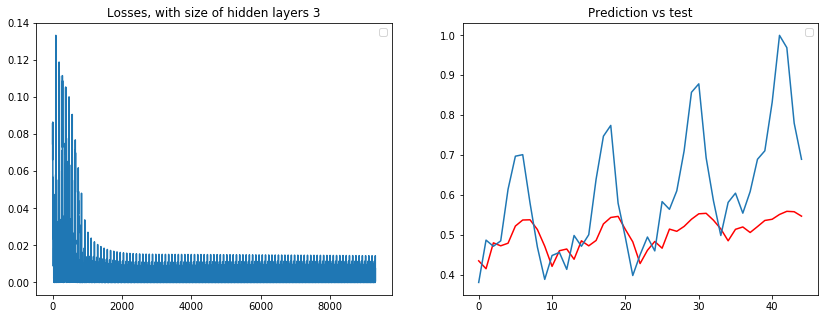

No handles with labels found to put in legend.
No handles with labels found to put in legend.


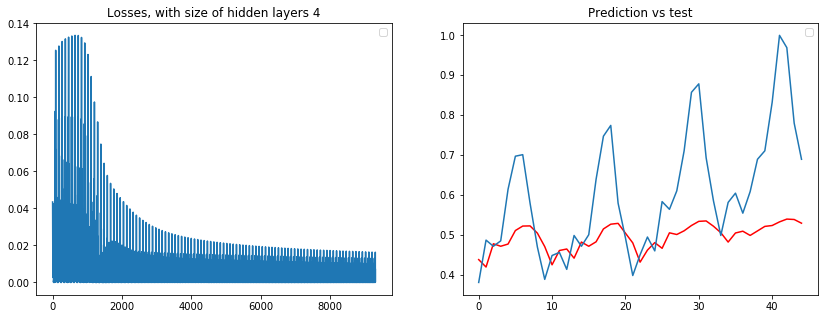

No handles with labels found to put in legend.
No handles with labels found to put in legend.


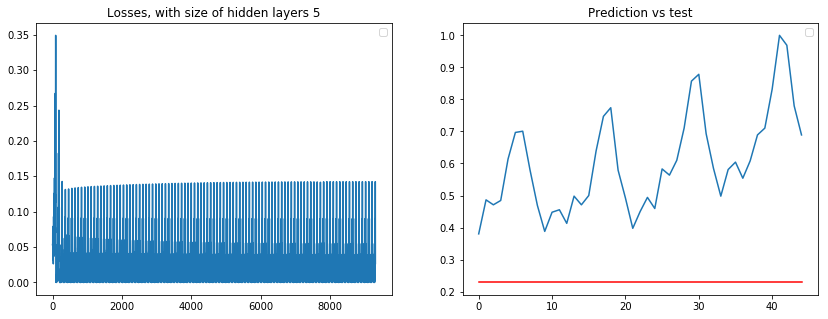

In [30]:
for i in range(1, 6):
    torch_gru = nn.GRU(input_size=1, hidden_size=1, num_layers=i)
    check(torch_gru, look_back=1, hidden=i)

наилучшее кол-во слоев - 1, наилучшее кол-во входных переменных - 1

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: